In [73]:
import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__

import SimpleITK

<h1>1. Importation des images</h1>

    Dossier patient contient 25 images format DICOM.

In [74]:
data_path = "c:/Patient"
output_path = working_path = "c:/Output/"
g = glob(data_path + '/*.dcm')


<h2>2. Fonctions d'assistance</h2>
    
    Ici, nous faisons deux fonctions d'assistance :
    
    . load_scan chargera toutes les images DICOM d'un dossier dans une liste pour manipulation.
    . Les valeurs de voxel dans les images sont brutes. get_pixels_hu convertit les valeurs brutes en unités Houndsfeld.

In [75]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



In [76]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = scans[0].RescaleIntercept if 'RescaleIntercept' in scans[0] else -1024
    slope = scans[0].RescaleSlope if 'RescaleSlope' in scans[0] else 1
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

<h1>3. Eneregistrement</h1>

    Enregistrer le nouvel ensemble de données sur le disque afin que nous n/'ayons pas à retraiter la pile à chaque fois.

In [77]:
np.save(output_path + "images_%d.npy" % (id), imgs)

<h1>4. Création d'un histogramme de toutes les données de voxels dans l'étude </h1>

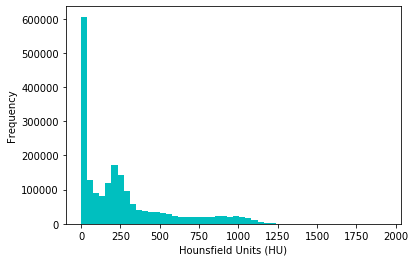

In [79]:
file_used=output_path+"images_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

<h1>5. Affichage d'une pile d'images</h1>

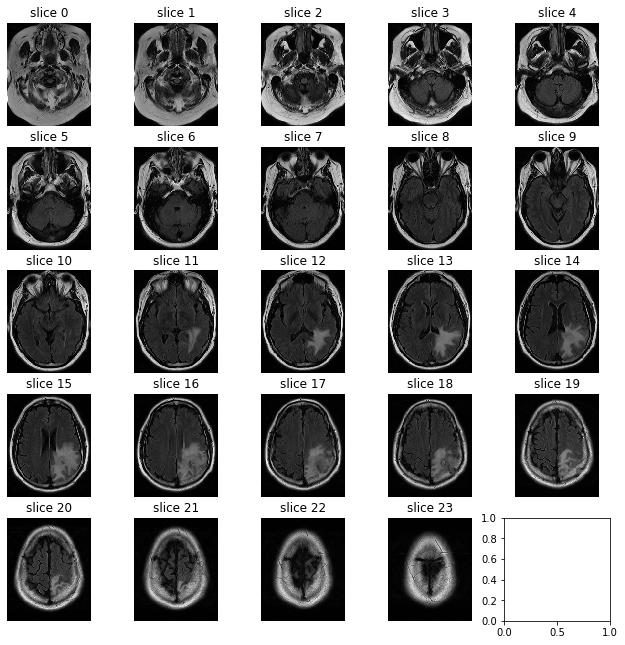

In [80]:
id = 0
imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))

def sample_stack(stack, rows=5, cols=5):
    fig,ax = plt.subplots(rows,cols,figsize=[11,11])
    for i in range(24):
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % i)
        ax[int(i/rows),int(i % rows)].imshow(stack[i],cmap="gray")
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)



<h1>6. Rééchantillonnage</h1>

    Rééchantillonnage (modifier l'épaisseur de chaque tranche).
    Bien que nous ayons chaque tranche individuelle, il n'est pas immédiatement clair de l'épaisseur de chaque tranche.

In [81]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 6.398209
Pixel Spacing (row, col): (0.687500, 0.687500) 


    Cela signifie que nous avons des tranches de 6.3 mm et que chaque voxel représente 0,6 mm.

In [83]:
id = 0
imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)



Shape before resampling	 (24, 320, 260)
Shape after resampling	 (154, 220, 179)


<h1>7. Segmentation</h1>

In [84]:
def segmentation(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0) 
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    labels = measure.label(dilation) 
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    if (display):
        fig, ax = plt.subplots(2, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Original")
        ax[1, 0].imshow(img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Original")
        ax[1, 1].imshow(dilation, cmap='gray')
        ax[1, 1].axis('off')
        
        plt.show()


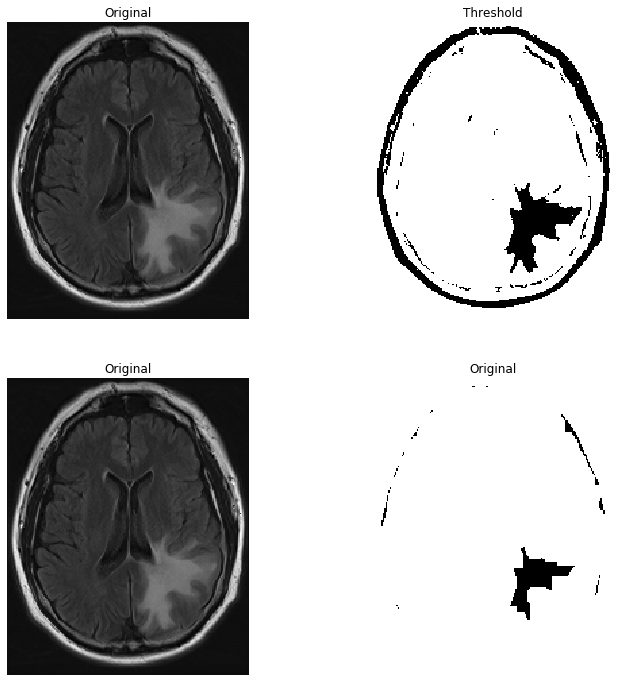

In [85]:
img = imgs_after_resamp[90]
segmentation(img, display=True)

<h1>8. Enregistrement des images traitées</h1>

In [86]:
np.save(output_path + "resultatfinale_%d.npy" % (id), imgs)